# SIIM-FISABIO-RSNA COVID-19 Detection using EfficientDet (Training)
  
### Performance Comparison of Similar Models

<figure>
<img src="https://blog.roboflow.com/content/images/2020/06/yolov5-performance.png" style="width:700px">
</figure>

Check out the [EfficientDet Research Paper ](https://arxiv.org/pdf/1911.09070.pdf)  


### EfficientDet Structure
![image](https://aihub-storage.s3.ap-northeast-2.amazonaws.com/file/efficientdet.png)

### Install Dependencies

In [1]:
!cp -r ../input/efficientdet-preprocessing-better-than-yolov5/Yet-Another-EfficientDet-Pytorch/ ./

In [2]:
import os
os.chdir('Yet-Another-EfficientDet-Pytorch/')

In [3]:
!pip install pycocotools webcolors

  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272434 sha256=8760dc25100808c256a6ff230e7ef0e094fee0600d89883f3ade94c8b7198cc7
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built pycocotools


### Training

#### Train a custom dataset with pretrained weights

In [4]:
!python train.py -c 0 -p siim --head_only True --lr 5e-3 --batch_size 32 --load_weights weights/efficientdet-d0.pth --num_epochs 10 --save_interval 100

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
[Warning] Ignoring Error(s) in loading state_dict for EfficientDetBackbone:
	size mismatch for classifier.header.pointwise_conv.conv.weight: copying a param with shape torch.Size([810, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([27, 64, 1, 1]).
	size mismatch for classifier.header.pointwise_conv.conv.bias: copying a param with shape torch.Size([810]) from checkpoint, the shape in current model is torch.Size([27]).
[Warning] Don't panic if you see this, this might be because you load a pretrained weights with different number of classes. The rest of the weights should be loaded already.
[Info] loaded weights: efficientdet-d0.pth, resuming checkpoint from step: 0
[Info] freezed backbone
Step: 99. Epoch: 0/10. Iteration: 100/158. Cls loss: 1.39850. Reg loss: 2.25544.checkpoint...
Step: 157. Epoch: 0/

### Resume training

In [5]:
! python train.py -c 0 -p siim --head_only False --lr 1e-3 --batch_size 16 --load_weights last  --num_epochs 40 --save_interval 100

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
using weights logs//siim/efficientdet-d0_9_1580.pth
[Info] loaded weights: efficientdet-d0_9_1580.pth, resuming checkpoint from step: 1580
Step: 1599. Epoch: 5/40. Iteration: 20/316. Cls loss: 0.52668. Reg loss: 2.04629checkpoint...
Step: 1699. Epoch: 5/40. Iteration: 120/316. Cls loss: 0.47382. Reg loss: 2.3127checkpoint...
Step: 1799. Epoch: 5/40. Iteration: 220/316. Cls loss: 0.54325. Reg loss: 2.3215checkpoint...
Step: 1895. Epoch: 5/40. Iteration: 316/316. Cls loss: 0.50317. Reg loss: 2.6619
Val. Epoch: 5/40. Classification loss: 0.47791. Regression loss: 2.17049. Total loss: 2.64840
Step: 1899. Epoch: 6/40. Iteration: 4/316. Cls loss: 0.53826. Reg loss: 2.52080.checkpoint...
Step: 1999. Epoch: 6/40. Iteration: 104/316. Cls loss: 0.36557. Reg loss: 1.8020checkpoint...
Step: 2099. Epoch: 6/40. Iteration: 204/316. Cls l

### Evaluation

#### mAP

In [6]:
weight_file = !ls logs/siim/
! python coco_eval.py -c 0 -p siim -w "logs/siim/{weight_file[-2]}"

running coco-style evaluation on project siim, weights logs/siim/efficientdet-d0_9_3160.pth...
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
100%|███████████████████████████████████████| 1267/1267 [01:42<00:00, 12.36it/s]
Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
BBox
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.65s).
Accumulating evaluation results...
DONE (t=0.49s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.124
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.070
 Average Recall     (AR) @[ IoU=0.50:0.95 | 

Average Precision (AP) @[IoU=0.50] score.

### Test Image Results

In [7]:
import torch
import random
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess
from colorama import Fore

In [8]:
compound_coef = 0
force_input_size = None  # set None to use default size
img_path = 'datasets/siim/val/'
test_cnt = 30

threshold = 0.1
iou_threshold = 0.1

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

class_names = ['Typical', 'Indeterminate', 'Atypical']
label2color = {
    '[0, 0, 0]': [0, 0, 0], # Typical Appearance
    '[1, 0, 0]': [66,9,255], # Typical Appearance
    '[0, 1, 0]': [255,186,8], # Indeterminate Appearance
    '[0, 0, 1]': [247,37,69], # Atypical Appearance
}
name2color = {
    'Negative' : [0, 0, 0], # Typical Appearance
    'Typical': [66,9,255], # Typical Appearance
    'Indeterminate': [255,186,8], # Indeterminate Appearance
    'Atypical': [247,37,69], # Atypical Appearance
}

obj_list = ['Typical','Indeterminate', 'Atypical']

# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size

imagelist = os.listdir(img_path)
random.shuffle(imagelist)
images = imagelist[:test_cnt]

![](https://aihub-storage.s3.ap-northeast-2.amazonaws.com/file/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA_2021-07-18_%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE_10.53.32.png)

### Load etc files

In [9]:
import pandas as pd
train_image = pd.read_csv('datasets/train_image.csv')
import json
with open('datasets/siim/annotations/instances_val.json', 'r') as f:
    files = json.load(f)

### Inference

In [10]:
imgs = []
for image in images:
    ori_imgs, framed_imgs, framed_metas = preprocess(img_path + image, max_size=input_size)

    if use_cuda:
        x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
    else:
        x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

    x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

    model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),

                                 # replace this part with your project's anchor config
                                 ratios=[(1.0, 1.0), (1.3, 0.8), (1.9, 0.5)],
                                 scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

    model.load_state_dict(torch.load('logs/siim/'+weight_file[-2]))
    model.requires_grad_(False)
    model.eval()

    if use_cuda:
        model = model.cuda()
    if use_float16:
        model = model.half()

    with torch.no_grad():
        features, regression, classification, anchors = model(x)

        regressBoxes = BBoxTransform()
        clipBoxes = ClipBoxes()

        out = postprocess(x,
                          anchors, regression, classification,
                          regressBoxes, clipBoxes,
                          threshold, iou_threshold)

    out = invert_affine(framed_metas, out)

    for i in range(len(ori_imgs)):
        if len(out[i]['rois']) == 0:
            continue
        for j in range(len(out[i]['rois'])):
            (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
            obj = obj_list[out[i]['class_ids'][j]]
            cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), name2color[obj], 2)
            score = float(out[i]['scores'][j])

            cv2.putText(ori_imgs[i], '{:.3f}'.format(score),
                        (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (255,255,255), 1)
            
    tmp = train_image[train_image.id==image[:-4]]
    label = tmp['label']
    img = cv2.imread(img_path + image)
    claz = tmp[class_names].values
    color = label2color[str(claz.tolist()[0])]

    for i in files['images']:
        if i['file_name'] == image:
            image_id = i['id']
    bboxes = []
    for i in files['annotations']:
        if i['image_id'] == image_id:
            bboxes.append(i['bbox'])
            
    for box in bboxes:
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]+box[0]), int(box[3]+box[1])),
            color, 2
        )
    imgs += [ori_imgs[0], img]

![](https://aihub-storage.s3.ap-northeast-2.amazonaws.com/file/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA_2021-07-18_%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE_10.53.32.png)

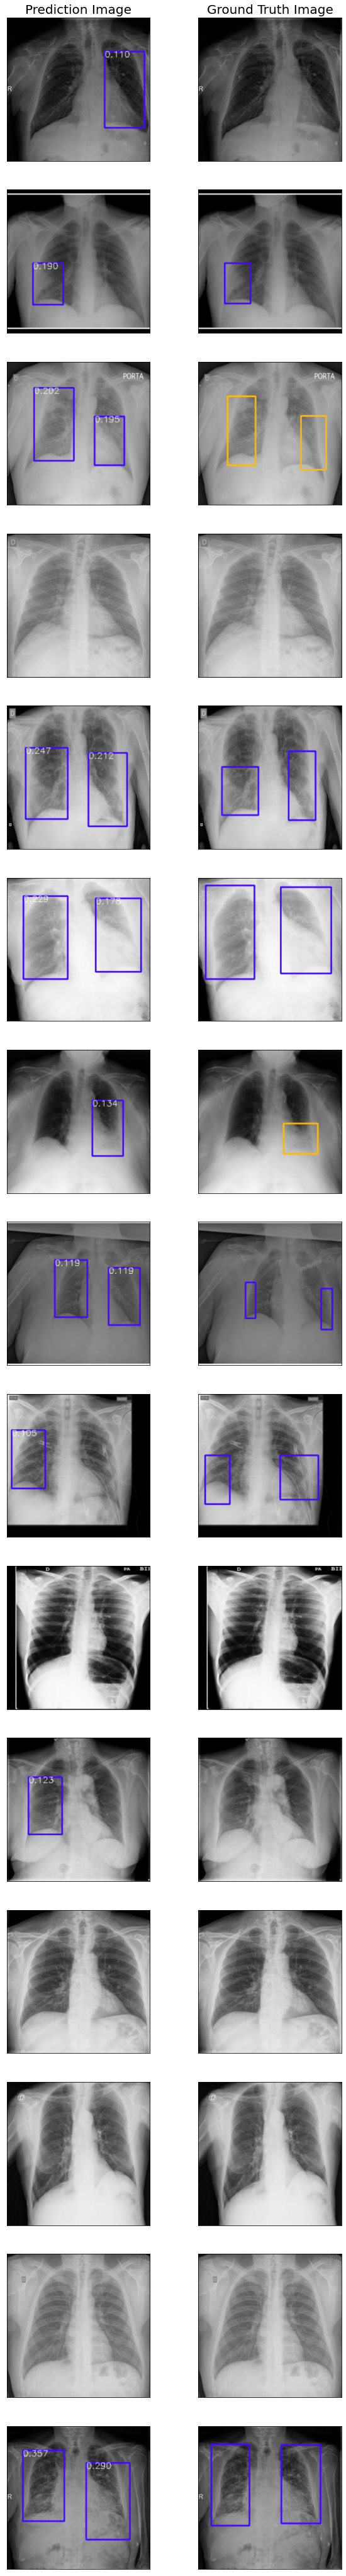

In [11]:
fig = plt.figure(figsize=(2*5, len(imgs)//2*5))
for i, img in enumerate(imgs[:30]):
    img = cv2.resize(img, (300,300))
    ax = fig.add_subplot(len(imgs)//2, 2, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title('Prediction Image',fontsize=20)
    elif i == 1:
        ax.set_title('Ground Truth Image',fontsize=20)
    plt.imshow(img)
plt.show()